<a href="https://colab.research.google.com/github/TVI-BIZ/NordN/blob/main/Flownet2_Colab_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Литературные источники:

Расположены в рекомендуемом порядке для ознаколмелния.

Научные статьи:
* Ilg E. et al. Flownet 2.0: Evolution of optical flow estimation with deep networks //Proceedings of the IEEE conference on computer vision and pattern recognition. – 2017. – С. 2462-2470. (https://openaccess.thecvf.com/content_cvpr_2017/papers/Ilg_FlowNet_2.0_Evolution_CVPR_2017_paper.pdf)

Видеолекции:
* "Оптический поток", Михаил Романов ["Samsung AI Innovation Campus - Russia"](https://youtu.be/CFBeb0Rwj2g)

Статьи на ит порталах:
* То, что вы хотели знать про оптический поток, но стеснялись спросить
(https://habr.com/ru/post/201406/)

* Generating optical flow using NVIDIA flownet2-pytorch implementation (https://towardsdatascience.com/generating-optical-flow-using-nvidia-flownet2-pytorch-implementation-d7b0ae6f8320?gi=840c37088f65)




# Импорт библиотек подключение Google диска с данными

In [1]:
!nvidia-smi

Sun Apr 18 06:35:36 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.67       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   61C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from PIL import Image
from skimage.transform import resize
import imageio
import os
import glob
import math

In [3]:
# подключаем Google диск к ВМ Google Colab'a
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [4]:
# укажем путь по которому хранится видео флотации, для которого мы хотим 
# оценивать поле векторов скоростей потока
vid_file= '/content/gdrive/MyDrive/NorNikel_hakaton/dataset1-1/F1_1_1_1.ts'

# Задаем путь по которому храниться маска кодирующая область интереса, часть 
# кадра видео по которому будут считать вектора скоростей потока
# маска == 1 потоки будут показаны, маска == 0  для этих точек произойдет 
# зануление векторов скоростей

# поумолчанию FlowNet2 будет оценивать скорости поток для всего кадра в том числе
# и для потока который стекают в желоб а его нам нужно игнорировать.
# скорость там существенно выше и при вычислении усредненной скорости тока по 
# всему кадру появятся погрешности.

# чтобы этого не происходило надо взять первый кадр видео, в любом растровом 
# редакторе (например MS Paint) закрасить белым ту область где мы хотим вычислять
# векторные поля скоростей и по кторой будем оценивать средняя скорость.

# !!! Это делает один раз для одной камеры флотации.
# если камера не меняет своего положения, менять маску не нужно.

# По умолчанию наша реализация работает с маской, чтобы работать без маски в 
# качестве маски можно уразать просто белый лист, тогда вектора будут оцениваться
# по всему кадру.
mask_path = '/content/gdrive/MyDrive/NorNikel_hakaton/dataset1-1/Mask_F1_1_1_1.jpg'

# если мы хоти наложить поверх цветовой визуализации поля векторов скорости
# линии тока(потока) и вывод усреденнной скорости потока по всей пене,
# то ставим этот флаг в True
# ели интересует только цветовая визуализация поля векторов скорости,
# то ставим False
flag_visualise_flows_and_speed = True

# Установка модели FlowNet2

## Устанавливаем неободимые версии фреймворка Torch и его компонентов

In [5]:
!pip install torch==1.0.0 torchvision==0.2.2 -f https://download.pytorch.org/whl/cu90/torch_stable.html

Looking in links: https://download.pytorch.org/whl/cu90/torch_stable.html
     |████████████████████████████████| 591.8MB 28kB/s 
     |████████████████████████████████| 71kB 10.4MB/s 
     |████████████████████████████████| 61kB 8.6MB/s 
ERROR: torchtext 0.9.1 has requirement torch==1.8.1, but you'll have torch 1.0.0 which is incompatible.
ERROR: spacy 2.2.4 has requirement tqdm<5.0.0,>=4.38.0, but you'll have tqdm 4.19.9 which is incompatible.
ERROR: fbprophet 0.7.1 has requirement tqdm>=4.36.1, but you'll have tqdm 4.19.9 which is incompatible.
  Found existing installation: torch 1.8.1+cu101
    Uninstalling torch-1.8.1+cu101:
      Successfully uninstalled torch-1.8.1+cu101
  Found existing installation: tqdm 4.41.1
    Uninstalling tqdm-4.41.1:
      Successfully uninstalled tqdm-4.41.1
  Found existing installation: torchvision 0.9.1+cu101
    Uninstalling torchvision-0.9.1+cu101:
      Successfully uninstalled torchvision-0.9.1+cu101


## Скачиваем все файлы FlowNet2 из репозитория и устанавливаем необходимые модули

In [6]:
import os
# скачать flownet2-pytorch source
!git clone https://github.com/Gauravv97/flownet2-pytorch.git
!mv /content/flownet2-pytorch /content/flownet2pytorch
os.chdir('./flownet2pytorch')
# установить специальные слои flownet2, которых нет в PyTorch изначально
!bash install.sh

Cloning into 'flownet2-pytorch'...
remote: Enumerating objects: 572, done.
remote: Total 572 (delta 0), reused 0 (delta 0), pack-reused 572
Receiving objects: 100% (572/572), 6.28 MiB | 35.16 MiB/s, done.
Resolving deltas: 100% (323/323), done.
running install
running bdist_egg
running egg_info
creating correlation_cuda.egg-info
writing correlation_cuda.egg-info/PKG-INFO
writing dependency_links to correlation_cuda.egg-info/dependency_links.txt
writing top-level names to correlation_cuda.egg-info/top_level.txt
writing manifest file 'correlation_cuda.egg-info/SOURCES.txt'
writing manifest file 'correlation_cuda.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_ext
building 'correlation_cuda' extension
creating build
creating build/temp.linux-x86_64-3.7
x86_64-linux-gnu-gcc -pthread -Wno-unused-result -Wsign-compare -DNDEBUG -g -fwrapv -O2 -Wall -g -fdebug-prefix-map=/build/python3.7-a56wZI/python3.7-3.7.10=. -fstack-protector

### Добавить утановленные пакеты в IPython system path

In [7]:
import os
os.sys.path.append('/root/.local/lib/python3.6/site-packages/resample2d_cuda-0.0.0-py3.6-linux-x86_64.egg')
os.sys.path.append('/root/.local/lib/python3.6/site-packages/correlation_cuda-0.0.0-py3.6-linux-x86_64.egg')
os.sys.path.append( '/root/.local/lib/python3.6/site-packages/channelnorm_cuda-0.0.0-py3.6-linux-x86_64.egg')

# Устанавливаем дополнительные пакеты и зависимости

In [8]:
!pip install pypng
!pip install tensorboardx
!pip install  setproctitle colorama scipy==1.1.0

     |████████████████████████████████| 655kB 20.4MB/s 
  Created wheel for pypng: filename=pypng-0.0.20-cp37-none-any.whl size=67163 sha256=dc60f871ac276a0c3571bcc41dabef412de02dd1878841629badf9a3b057ac83
  Stored in directory: /root/.cache/pip/wheels/41/6b/ef/0493b536b6d4722c2ae9486691b1d49b922b9877922beeabb3
Successfully built pypng
     |████████████████████████████████| 122kB 15.1MB/s 
     |████████████████████████████████| 31.2MB 99kB/s 
ERROR: plotnine 0.6.0 has requirement scipy>=1.2.0, but you'll have scipy 1.1.0 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1


## Скачиваем готовую предобученную модель FlowNet2

In [9]:
# скачиваем готовую предобученную модель FlowNet2 (всю модель с готовыми весами)
# данный код скачивает модель непосредственно из репозитория разработчика
from google_drive_downloader import GoogleDriveDownloader as gdd
gdd.download_file_from_google_drive(file_id='1hF8vS6YeHkx3j2pfCeQqqZGwA_PJq_Da',
                                    dest_path='./FlowNet2_checkpoint.pth.tar')

# возможно доступ к модели(файлу FlowNet2_checkpoint.pth.tar) будет закрыт,
# на всякий случай мы сохранили ее отдельно в папке на Google drive
# './/model_FlowNet2_pretrained//FlowNet2_checkpoint.pth.tar'

# Запуск предсказаний векторов скоростей flows моделью FlowNet2

### Разложим видео на картинки, каждая из которых представляет собой один кадр из видео

In [10]:
import os
def mkdir_ifnotexists(dir):
    if os.path.exists(dir):
        return
    os.mkdir(dir)

In [11]:
frame_pth='./frames'
mkdir_ifnotexists(frame_pth)
cmd = "ffmpeg -i %s -start_number 0 -vsync 0 %s/frame_%%06d.png" % (
            vid_file,
            frame_pth,
        )
os.system(cmd)

0

**Модель FlowNet2 решает задачу оптического потока**

Оптический поток (ОП) – изображение видимого движения, представляющее собой сдвиг каждой точки между двумя изображениями.

Для предсказания нужно вда последовательно идущих друг за другом кадра видео.

Он представляет собой поле скоростей (т. к. сдвиг с точностью до масштаба эквивалентен мгновенной скорости).

**В результате мы получим матрицы векторого поля скоростей частиц, которые будут оценивать скорости в пикселя изображения.**

**Таких матриц будет на 1 меньше чем кадро видео.**


### Сгенерируем .flo файлы используя FlowNet2

.flo файлы это файлы преставляющие собой бинарные матрицы векторого поля скоростей частиц, которые будут оценивать скорости в пикселя изображения. 

Они имет размерность (высота картинки в пикселях, ширина картинки в пикселях) каждый элемент которого представляет собой двумерный вектор скорости потока (x - компонента, у - компонента)

* В нашем случае, модель принимает на вход кадр видео (600, 800).
* Во время предсказания модель пережмет ее в картинку (256, 256).
* Сделает предсказание векторов скорстей потока и произведет обратное расширение почти до начального размера, но с некоторыми потерями получится (576, 768).
* И кадым элементом этой матрицы является двумерный вектор (x,y).
Поэтому итоговая размерность будет (576, 768, 2)

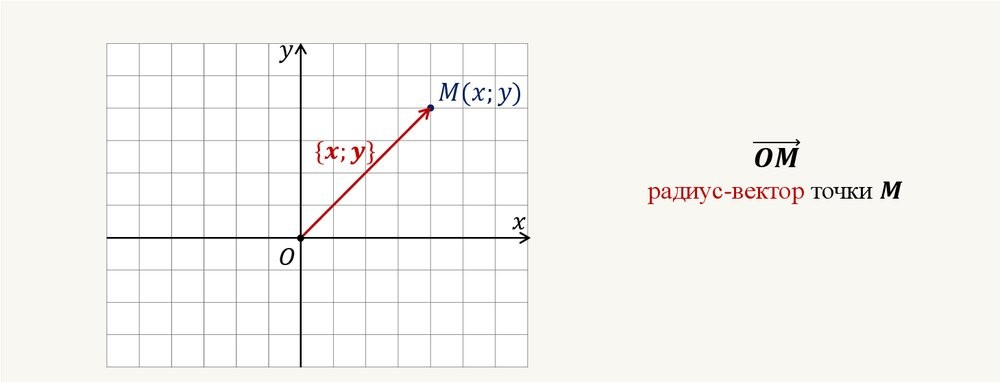

In [12]:
# запускаем модель FlowNet2 на предсказание векторного поля скоростей для 
# каждого кадра видео
!python main.py --inference --model FlowNet2 --save_flow --save ./output --inference_dataset ImagesFromFolder --inference_dataset_root ./frames/ --resume ./FlowNet2_checkpoint.pth.tar

Выходные данные были обрезаны до нескольких последних строк (5000).
Inference Averages for Epoch 0: L1: 7.658, EPE: 13.263:   7%|▏ | 121/1786.0 [00:22<04:55,  5.63it/s]
Inference Averages for Epoch 0: L1: 7.658, EPE: 13.263:   7%|▏ | 121/1786.0 [00:22<04:55,  5.63it/s]
Inference Averages for Epoch 0: L1: 7.642, EPE: 13.236:   7%|▏ | 121/1786.0 [00:22<04:55,  5.63it/s]
Inference Averages for Epoch 0: L1: 7.642, EPE: 13.236:   7%|▏ | 122/1786.0 [00:22<04:56,  5.61it/s]
Inference Averages for Epoch 0: L1: 7.642, EPE: 13.236:   7%|▏ | 122/1786.0 [00:22<04:56,  5.61it/s]
Inference Averages for Epoch 0: L1: 7.624, EPE: 13.206:   7%|▏ | 122/1786.0 [00:22<04:56,  5.61it/s]
Inference Averages for Epoch 0: L1: 7.624, EPE: 13.206:   7%|▏ | 123/1786.0 [00:22<04:57,  5.58it/s]
Inference Averages for Epoch 0: L1: 7.624, EPE: 13.206:   7%|▏ | 123/1786.0 [00:22<04:57,  5.58it/s]
Inference Averages for Epoch 0: L1: 7.622, EPE: 13.202:   7%|▏ | 123/1786.0 [00:22<04:57,  5.58it/s]
Inference Averages for 

# Здесь приведены функции для визуализации flo файлов

### Установим scipy==1.4.1, это тоже важная зависимость

In [13]:
!pip install scipy==1.4.1

     |████████████████████████████████| 26.1MB 117kB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: scipy 1.1.0
    Uninstalling scipy-1.1.0:
      Successfully uninstalled scipy-1.1.0


In [14]:
os.chdir('/content/flownet2pytorch')

### Определим функцию show_flow() для визуализации.

Первичный источник: https://github.com/sampepose/flownet2-tf/blob/master/src/flowlib.py

Поскольку нарисовать в каждом пикселе изображения вектор не представляется возможным, для визуализации векторов в каждом пикселе изображения используется цветовая кодировка.

Цветовая кодировка модуля и напрвления векторов скоростей в каждом пикселе изображения, приведена на рисунке ниже.

Является общепринятой. Функции ниже придерживаются данной цветовой маркировки.

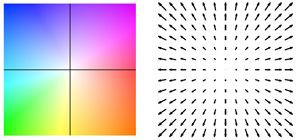

In [15]:
UNKNOWN_FLOW_THRESH = 1e7

def flow_to_image(flow):
    """
    Перевести матрицу потока в цветное изображение, показывающей вектора в 
    виде цветовой маркировки
    :param flow: матрица векторов скоростей
    :return: изображение с цветовой маркировкой всех векторов в каждом 
    его пикселе.
    """
    u = flow[:, :, 0]
    v = flow[:, :, 1]

    maxu = -999.
    maxv = -999.
    minu = 999.
    minv = 999.

    idxUnknow = (abs(u) > UNKNOWN_FLOW_THRESH) | (abs(v) > UNKNOWN_FLOW_THRESH)
    u[idxUnknow] = 0
    v[idxUnknow] = 0

    maxu = max(maxu, np.max(u))
    minu = min(minu, np.min(u))

    maxv = max(maxv, np.max(v))
    minv = min(minv, np.min(v))

    rad = np.sqrt(u ** 2 + v ** 2)
    maxrad = max(-1, np.max(rad))

    #print( "max flow: %.4f\nflow range:\nu = %.3f .. %.3f\nv = %.3f .. %.3f" % (maxrad, minu,maxu, minv, maxv))

    u = u/(maxrad + np.finfo(float).eps)
    v = v/(maxrad + np.finfo(float).eps)

    img = compute_color(u, v)

    idx = np.repeat(idxUnknow[:, :, np.newaxis], 3, axis=2)
    img[idx] = 0

    return np.uint8(img)

In [16]:
# Истоник :https://github.com/sampepose/flownet2-tf/blob/master/src/flowlib.py


import matplotlib.pyplot as plt
import numpy as np


def show_flow(filename):
    """
    визуализирует поле векторов скоростей в виде картинки с цветовой 
    маркировкой, используя matplotlib
    :param filename: flo-файл c векторами скоростей
    :return: None
    """
    flow = read_flow(filename)
    img = flow_to_image(flow)
    plt.imshow(img)
    plt.show()

def read_flow(filename):
    """
    считывает матрицу векторов скоростей из .flo файла
    :param filename: путь к .flo файлу
    :return: матрица векторов скоростей в виде numpy.array
    """
    f = open(filename, 'rb')
    magic = np.fromfile(f, np.float32, count=1)
    data2d = None

    if 202021.25 != magic:
        print ('Magic number incorrect. Invalid .flo file')
    else:
        w = int(np.fromfile(f, np.int32, count=1)[0])
        h = int(np.fromfile(f, np.int32, count=1)[0])
        #print("Reading %d x %d flo file" % (h, w))
        data2d = np.fromfile(f, np.float32, count=2 * w * h)
        # reshape data into 3D array (columns, rows, channels)
        data2d = np.resize(data2d, (h, w, 2))
    f.close()
    return data2d


def compute_color(u, v):
    """
    расчитать цветовую маркировку для векторов скоростей
    :param u: U горизонтальная компонента(x) вектора потока
    :param v: V вертикальная компонента(x) вектора потока
    :return: цвет для данного вектора скорости
    """
    [h, w] = u.shape
    img = np.zeros([h, w, 3])
    nanIdx = np.isnan(u) | np.isnan(v)
    u[nanIdx] = 0
    v[nanIdx] = 0

    colorwheel = make_color_wheel()
    ncols = np.size(colorwheel, 0)

    rad = np.sqrt(u**2+v**2)

    a = np.arctan2(-v, -u) / np.pi

    fk = (a+1) / 2 * (ncols - 1) + 1

    k0 = np.floor(fk).astype(int)

    k1 = k0 + 1
    k1[k1 == ncols+1] = 1
    f = fk - k0

    for i in range(0, np.size(colorwheel,1)):
        tmp = colorwheel[:, i]
        col0 = tmp[k0-1] / 255
        col1 = tmp[k1-1] / 255
        col = (1-f) * col0 + f * col1

        idx = rad <= 1
        col[idx] = 1-rad[idx]*(1-col[idx])
        notidx = np.logical_not(idx)

        col[notidx] *= 0.75
        img[:, :, i] = np.uint8(np.floor(255 * col*(1-nanIdx)))

    return img


def make_color_wheel():
    """
    Генерация цветовой маркировки для векторов скоростей
    :return: цветовую маркировку
    """
    RY = 15
    YG = 6
    GC = 4
    CB = 11
    BM = 13
    MR = 6

    ncols = RY + YG + GC + CB + BM + MR

    colorwheel = np.zeros([ncols, 3])

    col = 0

    # RY
    colorwheel[0:RY, 0] = 255
    colorwheel[0:RY, 1] = np.transpose(np.floor(255*np.arange(0, RY) / RY))
    col += RY

    # YG
    colorwheel[col:col+YG, 0] = 255 - np.transpose(np.floor(255*np.arange(0, YG) / YG))
    colorwheel[col:col+YG, 1] = 255
    col += YG

    # GC
    colorwheel[col:col+GC, 1] = 255
    colorwheel[col:col+GC, 2] = np.transpose(np.floor(255*np.arange(0, GC) / GC))
    col += GC

    # CB
    colorwheel[col:col+CB, 1] = 255 - np.transpose(np.floor(255*np.arange(0, CB) / CB))
    colorwheel[col:col+CB, 2] = 255
    col += CB

    # BM
    colorwheel[col:col+BM, 2] = 255
    colorwheel[col:col+BM, 0] = np.transpose(np.floor(255*np.arange(0, BM) / BM))
    col += + BM

    # MR
    colorwheel[col:col+MR, 2] = 255 - np.transpose(np.floor(255 * np.arange(0, MR) / MR))
    colorwheel[col:col+MR, 0] = 255

    return colorwheel

### Код для расцвечивания картинки

In [17]:
def get_overlayed_transparent_flow_on_frame(mask_path, flow_path_frame_1, path_frame_1, alpha=.3):
    """
    для кадра видео расположенного по пути path_frame_1 накладывает визуализацию 
    скоростей из файла flow_path_frame_1 с долей прозрачности alpha 
    по маске указывающей область интереса расположенной по пути mask_path.

    :mask_path: путь к картинке-маске указыающей область интереса
    :flow_path_frame_1: путь к файлу потока(векторов скоростей)
    :path_frame_1: путь к картинке кадру видео флотации
    :alpha=.3: уровень прозрачности визуализации векторов потока цветом

    :return: alphaBlended1, frontImage, background

        alphaBlended1 - кадр видео с наложенной на него визуализацией потоков
        frontImage - карта потоков по маске отдельно
        background - кадр из видео флотации
    """

    # считываем матрицу потоков
    flow_frame1 = read_flow(flow_path_frame_1)
    
    # считываем маcку картинку
    mask_img = imageio.imread(mask_path)

    # приводим размер макси созданный по первому кадру к картинке потока
    mask_img = resize(mask_img, (flow_frame1.shape[0], flow_frame1.shape[1]))

    # считываем первый кадр
    frame_img = imageio.imread(path_frame_1)

    # приводим размер макси созданный по первому кадру к картинок потока
    frame_img = resize(frame_img, (flow_frame1.shape[0], flow_frame1.shape[1]))

    frame_img = frame_img *255
    frame_img = frame_img.astype('int')

    # считываем сохраненную матрицу потоков как картинку
    flow_img = flow_to_image(read_flow(flow_path_frame_1))

    # оставляем из картинки потоков только область интереса выденную маской
    img = mask_img * flow_img
    img = img.astype('int')

    # добавляем в области нулей, получившихся от маски области из кадра
    img2 = img + (img == 0) * frame_img

    # Convert image to RGBA
    frontImage = Image.fromarray(np.uint8(img2)).convert('RGB').convert("RGBA")
    
    # Convert image to RGBA
    background = Image.fromarray(np.uint8(frame_img)).convert('RGB').convert("RGBA")

    # alpha-blend the images with varying values of alpha
    alphaBlended1 = Image.blend(background, frontImage, alpha)

    # Display the alpha-blended images
    return alphaBlended1, frontImage, background

In [18]:
def add_flow_visualisation_on_image(flow_on_frame_img, flow_path_frame_1,
                                    mask_path, save_path):
    """
    Накладывает на изображение с цветовой визуализацией поля векторов скорости
    flow_on_frame_img, визуализацию векторов в виде линий тока(потока), 
    рассчитывает среднюю скорость по всему что находится в внутри зоны интереса
    задаваемой маской, расположенной по пути  mask_path и сохраняет данную 
    визуализацию в виде картинки по указанному в save_path пути.

    :mask_path: путь к картинке-маске указыающей область интереса
    :flow_path_frame_1: путь к файлу потока(векторов скоростей)
    :path_frame_1: путь к картинке кадру видео флотации
    :alpha=.3: уровень прозрачности визуализации векторов потока цветом

    :return: alphaBlended1, frontImage, background

        alphaBlended1 - кадр видео с наложенной на него визуализацией потоков
        frontImage - карта потоков по маске отдельно
        background - кадр из видео флотации
    """

    # считываем матрицу потоков
    flow_frame1 = read_flow(flow_path_frame_1)

    # считываем маcку картинку
    mask_img = imageio.imread(mask_path)

    # приводим размер макси созданный по первому кадру к картинке потока
    mask_img = resize(mask_img, (flow_frame1.shape[0], flow_frame1.shape[1]))

    # обрежем полученный расчет поля векторов скоростей по максе,
    # выделяющей область интереса
    flow_frame1 = crop_flows_by_mask(flow_frame1, mask_img)

    # Посчитаем усредененный вектор скорости
    average_vector = calc_averadge_vector(flow_frame1)

    # Визуализация 
    # 1D arrays
    x = np.arange(0, flow_frame1.shape[1], 1)
    y = np.arange(0, flow_frame1.shape[0], 1)
    
    # Meshgrid
    X,Y = np.meshgrid(x,y)

    fig = plt.figure(figsize=(15, 15))
    plt.imshow(flow_on_frame_img)
    plt.text(flow_frame1.shape[1]//2, flow_frame1.shape[0]//2,
             s=f'Средняя скорость потока {math.hypot(*average_vector):.2}',
             fontsize=20,
             horizontalalignment='center')
    plt.streamplot(X,Y, flow_frame1[:,:,0], flow_frame1[:,:,1],
                density=1, maxlength = 2, linewidth=1, 
                arrowsize =2, color='#A23BEC')
    # plt.axis('off')
    plt.xlim(0, flow_frame1.shape[1])
    plt.ylim(flow_frame1.shape[0], 0)
    plt.axis('off')
    
    # сохраняем почти без рамок
    plt.savefig(save_path, bbox_inches="tight", pad_inches=0)
    plt.close()

In [19]:
def crop_flows_by_mask(flow_frame1, mask_img):
    # занулить все вектора потока в матрице flow_frame1, которые выходят за 
    # границу маски mask_img
    flow_frame1[:,:,0] = mask_img[:,:,0] * flow_frame1[:,:,0]
    flow_frame1[:,:,1] = mask_img[:,:,0] * flow_frame1[:,:,1]

    return flow_frame1

In [20]:
def calc_averadge_vector(flow_frame):
    # Расчитать усредненный вектор скорости потока по всем векторам из 
    # flow_frame
    average_vector = [flow_frame[:,:,0].mean(), flow_frame[:,:,1].mean()]
    return average_vector

### Отрисовываем потоки на первом кадре видео (Это просто тест для работы все что внутри подзаголовка не нужно)

In [26]:
flow_path_frame_1 = '/content/gdrive/MyDrive/NorNikel_hakaton/dataset1-1/F1_1_1_1_000000.flo'
path_frame_1 = '/content/gdrive/MyDrive/NorNikel_hakaton/dataset1-1/F1_1_1_1_frame_000000.png'

#### Читаем файл векторов оптического потока они пропорциональны скоростям

In [27]:
flow_frame1 = read_flow(flow_path_frame_1)

In [28]:
flow_frame1.shape

(576, 768, 2)

In [29]:
flow_on_frame_img, flow_img, frame_img = get_overlayed_transparent_flow_on_frame(mask_path, flow_path_frame_1, path_frame_1)

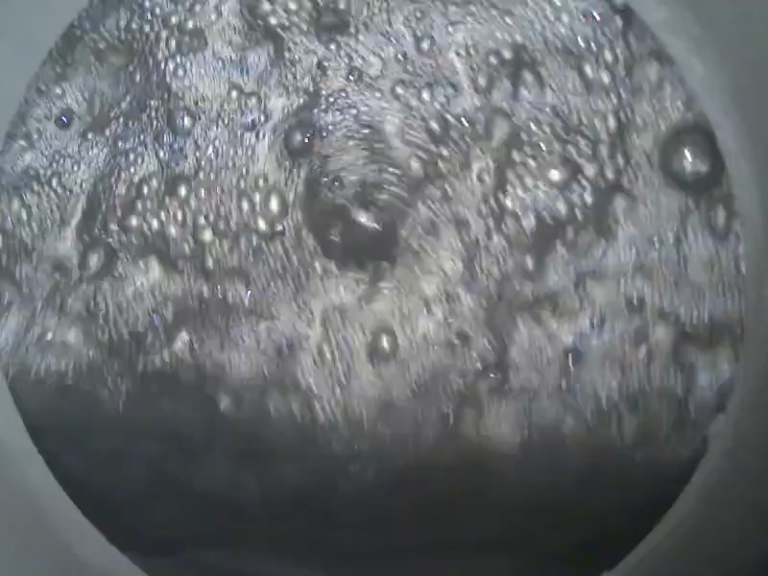

In [30]:
# посмотрим на кадр видео
frame_img

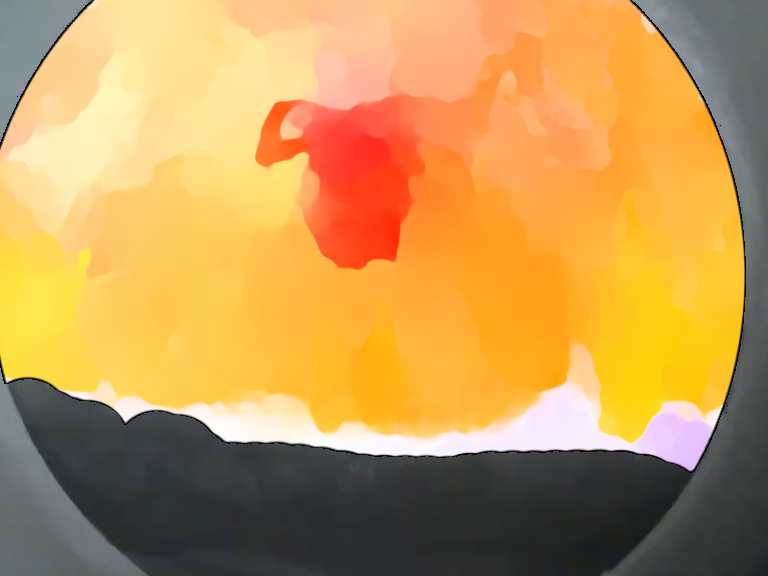

In [31]:
# посмотрим на визуализацию потоков
flow_img

#### Визуализация потоков(векторов скоростей) по типу дополненной реальности на кадрах видео

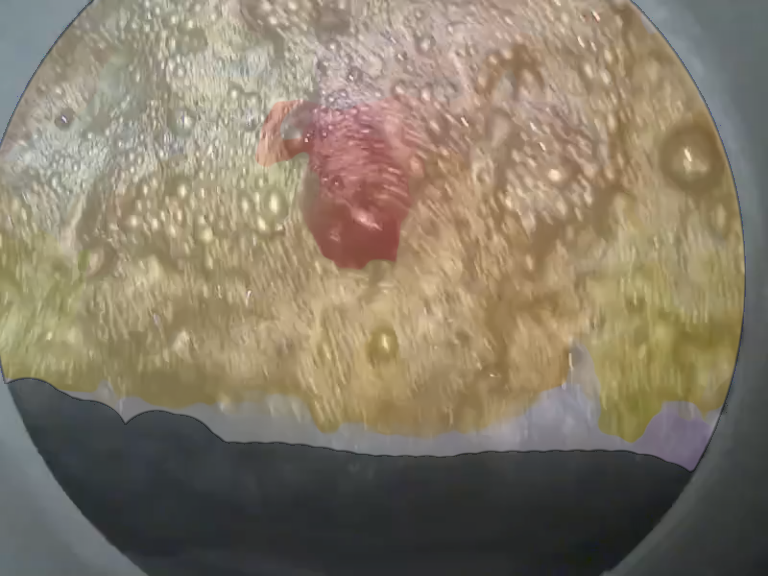

In [32]:
# кадр дополненнный векторами потока
flow_on_frame_img

In [34]:
# Наложим на изображение с цветовой визуализацией поля векторов скорости
# flow_on_frame_img, визуализацию векторов в виде линий тока(потока), 
# рассчитывает среднюю скорость по всему что находится в внутри зоны интереса
# задаваемой маской, расположенной по пути  mask_path и сохраняет данную 
# визуализацию в виде картинки по указанному в save_path пути.
add_flow_visualisation_on_image(flow_on_frame_img, flow_path_frame_1, mask_path, save_path='test.png')

In [ ]:
#Подводить статистику по моулям векторов? #TODO:(не реализовано)
flows_modules = np.sqrt(flow_frame1[:,:,0]**2 + flow_frame1[:,:,1]**2)

In [ ]:
flows_modules = flows_modules.flatten()

### Сохраяем визуализации потока на каждом кадре видео как картинки

In [36]:
def mkdir_ifnotexists(dir):
    if os.path.exists(dir):
        return
    os.mkdir(dir)

In [35]:
# удалить предидущий результат, - всю папку FlowFrames
import shutil

shutil.rmtree('/content/flownet2pytorch/FlowFrames')

In [37]:
flow_dir_pth='/content/flownet2pytorch/output/inference/run.epoch-0-flow-field/'
frame_dir_pth = '/content/flownet2pytorch/frames/'

In [38]:
frames_pths = sorted(glob.glob(frame_dir_pth + '*.png'))

In [ ]:
mkdir_ifnotexists('./FlowFrames')

for frame_path in frames_pths:
    number_frame = os.path.split(frame_path)[-1].split('_')[-1].split('.')[0]
    flow_path = flow_dir_pth + number_frame + '.flo'
    # получаем кадр с наложенной на нее визуализацией потоков
    flow_on_frame_img = get_overlayed_transparent_flow_on_frame(mask_path, flow_path, frame_path)[0]
    save_path = './FlowFrames/' + number_frame + '.flo.png'
    
    if flag_visualise_flows_and_speed:
        add_flow_visualisation_on_image(flow_on_frame_img, flow_path, mask_path, save_path=save_path)
        print(save_path)
    else:
        flow_on_frame_img.save(save_path)
        print(save_path)

./FlowFrames/000000.flo.png
./FlowFrames/000001.flo.png
./FlowFrames/000002.flo.png
./FlowFrames/000003.flo.png
./FlowFrames/000004.flo.png
./FlowFrames/000005.flo.png
./FlowFrames/000006.flo.png
./FlowFrames/000007.flo.png
./FlowFrames/000008.flo.png
./FlowFrames/000009.flo.png
./FlowFrames/000010.flo.png
./FlowFrames/000011.flo.png
./FlowFrames/000012.flo.png
./FlowFrames/000013.flo.png
./FlowFrames/000014.flo.png
./FlowFrames/000015.flo.png
./FlowFrames/000016.flo.png
./FlowFrames/000017.flo.png
./FlowFrames/000018.flo.png
./FlowFrames/000019.flo.png
./FlowFrames/000020.flo.png
./FlowFrames/000021.flo.png
./FlowFrames/000022.flo.png
./FlowFrames/000023.flo.png
./FlowFrames/000024.flo.png
./FlowFrames/000025.flo.png
./FlowFrames/000026.flo.png
./FlowFrames/000027.flo.png
./FlowFrames/000028.flo.png
./FlowFrames/000029.flo.png
./FlowFrames/000030.flo.png
./FlowFrames/000031.flo.png
./FlowFrames/000032.flo.png
./FlowFrames/000033.flo.png
./FlowFrames/000034.flo.png
./FlowFrames/000035.

### Собираем видео из покадровой визуализации потока

In [ ]:
os.system('ffmpeg -r 24 -i FlowFrames/%6d.flo.png -vcodec libx264 -b 10M -y FlowVideo.mp4  ')